# Alarm Logs in Packaging Industry (ALPI)

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [81]:
data_path = "../data/alarms-log-data/raw/alarms.csv"
df = pd.read_csv(data_path)
df["timestamp"] = pd.to_datetime(df["timestamp"])

display(df.head())

print("Num rows: ", len(df))

,timestamp,alarm,serial
0,2019-02-21 19:57:57.532,139,4
1,2019-02-21 19:58:28.293,139,4
2,2019-02-21 19:58:32.853,139,4
3,2019-02-21 19:59:05.387,139,4
4,2019-02-21 20:02:05.832,139,4


Num rows:  444834


In [89]:
df_sec = df.copy()
df_sec["timestamp"] = df_sec["timestamp"].dt.ceil(freq='s') # set frequency to seconds
df_sec = df_sec.drop_duplicates()
df_sec = df_sec.reset_index(drop=True)

display(df_sec.head())
print("Num rows:", len(df_sec))

,timestamp,alarm,serial
0,2019-02-21 19:57:58,139,4
1,2019-02-21 19:58:29,139,4
2,2019-02-21 19:58:33,139,4
3,2019-02-21 19:59:06,139,4
4,2019-02-21 20:02:06,139,4


Num rows: 442797


In [87]:
df_min = df.copy()
df_min["timestamp"] = df_min["timestamp"].dt.ceil(freq='min')
df_min = df_min.drop_duplicates()
df_min = df_min.reset_index(drop=True)

display(df_min.head())
print("Num rows:", len(df_min))

,timestamp,alarm,serial
0,2019-02-21 19:58:00,139,4
1,2019-02-21 19:59:00,139,4
2,2019-02-21 20:00:00,139,4
3,2019-02-21 20:03:00,139,4
4,2019-02-21 20:15:00,139,4


Num rows: 332805


In [70]:
df.drop_duplicates()

,timestamp,alarm,serial
0,2019-02-21 19:58:00,139,4
1,2019-02-21 19:59:00,139,4
3,2019-02-21 20:00:00,139,4
4,2019-02-21 20:03:00,139,4
7,2019-02-21 20:15:00,139,4
...,...,...,...
444828,2020-06-15 22:53:00,139,19
444829,2020-06-15 22:54:00,139,19
444830,2020-06-15 22:57:00,139,19
444831,2020-06-15 23:04:00,139,19


In [67]:
df["timestamp"].dt.ceil(freq='min')

0        2019-02-21 19:58:00
1        2019-02-21 19:59:00
2        2019-02-21 19:59:00
3        2019-02-21 20:00:00
4        2019-02-21 20:03:00
                 ...        
444829   2020-06-15 22:54:00
444830   2020-06-15 22:57:00
444831   2020-06-15 23:04:00
444832   2020-06-15 23:04:00
444833   2020-06-15 23:15:00
Name: timestamp, Length: 444834, dtype: datetime64[ns]

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444834 entries, 0 to 444833
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  444834 non-null  datetime64[ns]
 1   alarm      444834 non-null  int64         
 2   serial     444834 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 10.2 MB


In [43]:
machines = df["serial"].value_counts()
machines = pd.DataFrame(machines)
machines = machines.sort_values(by=["serial"])
machines.head()

,serial
19,221
4,2118
18,2813
16,3569
11,8202


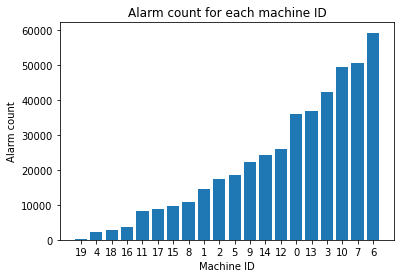

In [41]:
machine_ids = list(map(lambda x: str(x), machines.index))

plt.bar(machine_ids, machines.serial)
plt.title("Alarm count for each machine ID")
plt.xlabel("Machine ID")
plt.ylabel("Alarm count")
plt.show()

In [45]:
alarms = df["alarm"].value_counts()
alarms = pd.DataFrame(alarms)
alarms = alarms.sort_values(by=["alarm"])
alarms.head()

,alarm
59,1
49,1
50,1
81,1
62,1


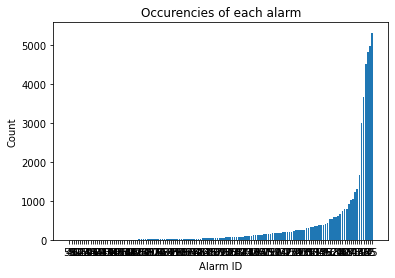

In [92]:
alarm_ids = list(map(lambda x: str(x), alarms.index))


plt.bar(alarm_ids[:-10], alarms.alarm[:-10])
plt.title("Occurencies of each alarm")
plt.xlabel("Alarm ID")
plt.ylabel("Count")
plt.show()

In [50]:
# Dataset for the machine id 4
df4 = df[df["serial"] == 4]
df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2118 entries, 0 to 2117
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  2118 non-null   datetime64[ns]
 1   alarm      2118 non-null   int64         
 2   serial     2118 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 66.2 KB


In [51]:
df4

,timestamp,alarm,serial
0,2019-02-21 19:57:58,139,4
1,2019-02-21 19:58:29,139,4
2,2019-02-21 19:58:33,139,4
3,2019-02-21 19:59:06,139,4
4,2019-02-21 20:02:06,139,4
...,...,...,...
2113,2020-06-15 21:35:02,31,4
2114,2020-06-16 15:11:38,26,4
2115,2020-06-16 15:12:10,26,4
2116,2020-06-16 15:12:31,26,4


In [52]:
df4["alarm"].unique()

array([139,  98,  26,  27,  29,  51,  30, 111, 138,  12,  78,  31,   1,
        47, 131,  39,  18,  28,  45,  21,  22,  46, 129, 123, 121,  55,
        34,  25,  17,  48,  37,   0,  32,  79])

In [62]:
df4["timestamp"].max() - df4["timestamp"].min()

Timedelta('480 days 19:14:39')